### Convert Flickr27 logos dataset to YOLO V5 format

This Notebook contains the code needed to convert annotation for the Flickr27 dataset in YOLO v7 format

In [1]:
import cv2
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

%matplotlib inline

In [2]:
# the txt file format for a line is
# 144503924.jpg Adidas 1 38 12 234 142
# where 1 after Adidas is the split number

# Image filename
# Class name
# Training subset of class (1,...,6)
# Coordinates of the top left and bottom right corners (x1 y1 x2 y2)

In [3]:
#
# functions
#

# does the conversion for a single BB
def convert_bb_2_yolov5(flickr_BB, image_height, image_width):
    
    # flickr_BB is (x1 y1 x2 y2)
    x1 = flickr_BB[0]
    y1 = flickr_BB[1]
    x2 = flickr_BB[2]
    y2 = flickr_BB[3]
    
    # check
    assert x1 <= image_width
    assert x2 <= image_width
    assert y1 <= image_height
    assert y2 <= image_height
    
    # compute xc, yc, must be scaled
    xc = (x1 + x2)/(2. * image_width)
    yc = (y1 + y2)/(2. * image_height)
    
    hgt = (y2 - y1)/image_height
    wdt = (x2 - x1)/image_width
    
    # yolo_BB is <xc> <yc> <width> <height> scaled
    yolo_BB = [xc, yc, wdt, hgt]
    
    return yolo_BB
    
# test returning back
def yolo_2_cv2(yolo_bb, image_hgt, image_wdt):
    # yolobb is an array of 4 float number <x> <y> <width> <height>
    assert (len(yolo_bb) == 4)
    
    # image_hgt, image_wdt are in pixels
    
    # compute absolute pixels of center
    xc = int(yolo_bb[0] * image_wdt)
    yc = int(yolo_bb[1] * image_hgt)
    
    half_abs_wdt = int((yolo_bb[2] * image_wdt)/2)
    half_abs_hgt = int((yolo_bb[3] * image_hgt)/2)
    
    start_point = (xc - half_abs_wdt , yc - half_abs_hgt)
    end_point = (xc + half_abs_wdt, yc + half_abs_hgt)
    
    return start_point, end_point

In [4]:
# globals

# file with annotations
ANNOT_FILE = "flickr_logos_27_dataset_training_set_annotation.txt"

SORTED_ANNOT_FILE = "sorted_flickr_logos_27_dataset_training_set_annotation.txt"

# the directory containing jpg files
IMAGES_INPUT_DIR = "flickr_logos_27_dataset_images/"

# the directory in which we produce annotations files in YOLO V% PyTorch format
OUTPUT_DIR = "./flickr_logos_27_yolo_annotations"

### Build the output dir, if not existing

In [5]:
if not os.path.exists(OUTPUT_DIR):
    os.mkdir(OUTPUT_DIR)

In [6]:
### analyze the annotations files

In [7]:
col_names = ['file_name', 'brand_name', 'split_num', 'x1', 'y1', 'x2', 'y2']

annot_df = pd.read_csv(ANNOT_FILE, sep=" ", header=None, names=col_names, index_col=False)

annot_df.head()

,file_name,brand_name,split_num,x1,y1,x2,y2
0,144503924.jpg,Adidas,1,38,12,234,142
1,2451569770.jpg,Adidas,1,242,208,413,331
2,390321909.jpg,Adidas,1,13,5,89,60
3,4761260517.jpg,Adidas,1,43,122,358,354
4,4763210295.jpg,Adidas,1,83,63,130,93


In [8]:
# better this way: list of all brands
BRANDS = sorted(annot_df['brand_name']. unique())

N_BRANDS = len(BRANDS)

In [9]:
print(f"There are {annot_df['file_name'].nunique()} distinct images")
print(f"There are {annot_df.shape[0]} rows")
print(f"We have {N_BRANDS} brands in the dataset")

There are 809 distinct images
There are 4536 rows
We have 27 brands in the dataset


In [10]:
# we don't need the split columns and we need to remove duplicates (same rows in different split)
# removing duplicates and splits, processing is much faster
annot_df = annot_df.drop(columns=['split_num'])

# remove duplicates (due to splits)
annot_df = annot_df.drop_duplicates()

# the original file is not sorted. We need to sort to better process it
# sort on file_name
annot_df = annot_df.sort_values('file_name')

# save the sorted annotation file
annot_df.to_csv(SORTED_ANNOT_FILE, sep= ' ', index=None, header=None)

In [11]:
# code the brands (starting with 0)
dict_brands = {}

for i, brand in enumerate(BRANDS):
    dict_brands[i] = brand

inv_dict_brands = {v: k for k, v in dict_brands.items()}

print(dict_brands)

{0: 'Adidas', 1: 'Apple', 2: 'BMW', 3: 'Citroen', 4: 'Cocacola', 5: 'DHL', 6: 'Fedex', 7: 'Ferrari', 8: 'Ford', 9: 'Google', 10: 'HP', 11: 'Heineken', 12: 'Intel', 13: 'McDonalds', 14: 'Mini', 15: 'Nbc', 16: 'Nike', 17: 'Pepsi', 18: 'Porsche', 19: 'Puma', 20: 'RedBull', 21: 'Sprite', 22: 'Starbucks', 23: 'Texaco', 24: 'Unicef', 25: 'Vodafone', 26: 'Yahoo'}


In [12]:
# inverse dict
print(inv_dict_brands)

{'Adidas': 0, 'Apple': 1, 'BMW': 2, 'Citroen': 3, 'Cocacola': 4, 'DHL': 5, 'Fedex': 6, 'Ferrari': 7, 'Ford': 8, 'Google': 9, 'HP': 10, 'Heineken': 11, 'Intel': 12, 'McDonalds': 13, 'Mini': 14, 'Nbc': 15, 'Nike': 16, 'Pepsi': 17, 'Porsche': 18, 'Puma': 19, 'RedBull': 20, 'Sprite': 21, 'Starbucks': 22, 'Texaco': 23, 'Unicef': 24, 'Vodafone': 25, 'Yahoo': 26}


### Do some tests

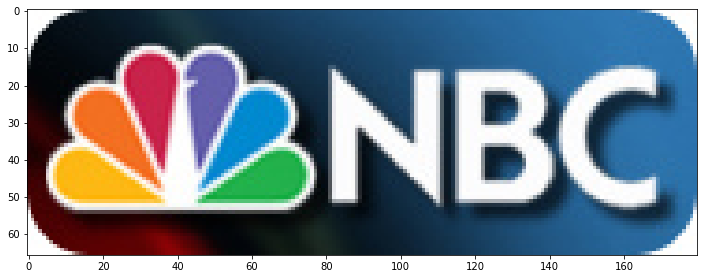

In [21]:
IMAGE_NAME = IMAGES_INPUT_DIR + "/" + "1075391489.jpg"

# read the image from the file
image = cv2.imread(IMAGE_NAME)
# we need it otherwise blue becomes red (checked on Mac). CV2 when read the image use BGR
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(12, 9))
plt.imshow(image);

In [14]:
# the row from flickr annotation file
# 144503924.jpg Adidas 1 38 12 234 142
# 2451569770.jpg Adidas 1 242 208 413 331 
# 1075391489.jpg Nbc 6 2 4 77 58

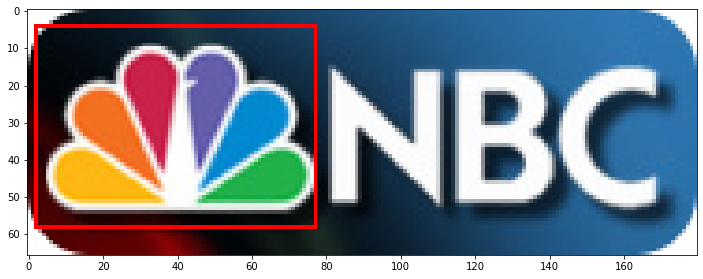

In [15]:
# add the BB

#flickr_BB has the format expected by CV2 no conversion needed
start_point = (2, 4) 
end_point = (77, 58)

# for plotting
# Red color in RGB (image is already in RGB)
color = (255, 0, 0)
  
# Line thickness of 1 px
thickness = 1
  
# Using cv2.rectangle() method
# Draw a rectangle with red line borders of thickness of 2 px
image = cv2.rectangle(image, start_point, end_point, color, thickness)

plt.figure(figsize=(12, 9))
plt.imshow(image);

In [16]:
# test the conversion function
flickr_BB = [2, 4, 77, 58]

image_height = image.shape[0]
image_width = image.shape[1]

yolo_BB = convert_bb_2_yolov5(flickr_BB, image_height, image_width)

yolo_BB

[0.21944444444444444,
 0.4696969696969697,
 0.4166666666666667,
 0.8181818181818182]

In [17]:
flickr_back_BB = yolo_2_cv2(yolo_BB, image_height, image_width)

flickr_back_BB

((2, 4), (76, 58))

In [18]:
# OK

### Batch conversion in YOLO V5 PyTorch format

produce a .txt for each image
for each object and BB there is a row in the file
<object-class> <xc> <yc> <width> <height>
    
we assume that the flickr annotation file is ordered on image name. If the image name changes, it has finished with that image

In [19]:
%%time

# line is: 144503924.jpg Adidas 38 12 234 142 
# split_num has been removed

# output will be produced in OUTPUT_DIR (see above)

n_images = 0
n_reads = 0
n_anomalies = 0
old_image_name = "NA"
annot_file_name = ""
obj_file = None

with open(SORTED_ANNOT_FILE, "r") as file:
    print("Reading and processing records from annotation file...")
    for line in file:
        fields = line.split(" ")
        
        img_name = fields[0]
        
        logo = fields[1]
        coded_logo = inv_dict_brands[logo]
        
        # sorted file doesn't contain split_num (removed)
        
        # BB rectangle
        # need to convert to int and remove '\n' for the last value
        flickr27_BB = np.array(fields[2:6], dtype = 'int32')
        
        # check if image changed to see if need to create a new file
        if old_image_name != img_name:
            # image changed: new image
            n_images += 1
            
            # prepare for next step
            old_image_name = img_name
            
            # remove .jpg
            parts_img_name = img_name.split(".")
            # new file name
            annot_file_name = parts_img_name[0] + ".txt"
            annot_file_pathname = OUTPUT_DIR + "/" + annot_file_name
            
            # close the old file and open a new one
            if (obj_file is not None) and (obj_file.closed == False):
                obj_file.close()
                
            obj_file = open(annot_file_pathname, mode="w") 
            
        # compute yolo BB
        try:
            # need to read each images to get hgt and wdt, needed for the conversion
            image = cv2.imread(IMAGES_INPUT_DIR + "/" + img_name)
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            hgt, wdt, channels = image.shape
            
            # convert
            yolo_BB = convert_bb_2_yolov5(flickr27_BB, hgt, wdt)
            
            # write in txt file (<object-class> <x> <y> <width> <height>)
            my_record = f"{coded_logo} {yolo_BB[0]} {yolo_BB[1]} {yolo_BB[2]} {yolo_BB[3]}\n"
            obj_file.write(my_record)
            
            n_reads += 1
            
            # print progress
            if n_reads%100 == 0:
                print(f"read {n_reads} records...")
                
        except Exception as e:
            n_anomalies += 1
            print('Exception on image:')
            print(img_name)
            print(flickr27_BB)
            print(e)
    
    # closing last
    if (obj_file is not None) and (obj_file.closed == False):
        obj_file.close()
            
    print()
    print(f"total images {n_images}")
    print(f"total reads {n_reads}")
    print(f"total anomalies {n_anomalies}")
    print()

Reading and processing records from annotation file...
read 100 records...
read 200 records...
read 300 records...
read 400 records...
read 500 records...
read 600 records...
read 700 records...
read 800 records...
read 900 records...
read 1000 records...
read 1100 records...
read 1200 records...

total images 809
total reads 1261
total anomalies 0

CPU times: user 3min 21s, sys: 25.9 s, total: 3min 47s
Wall time: 10.6 s


In [ ]:
# the entire conversion require around 10 secs.